In [5]:
import os
import pandas as pd
from skimage.io import imread
import pyclesperanto_prototype as cle
from stardist.matching import matching_dataset
import matplotlib.pyplot as plt
import numpy as np
from tifffile import imread
from tqdm import tqdm
import statistics
import json
import importlib

import sys
from pathlib import Path

cwd = os.getcwd()
# print(f"Working dir: {cwd}")
module_path = os.path.abspath(Path(cwd).parents[3])
# print(f"Module dir: {module_path}")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.tools.utils import load_yaml, load_json, write_json
from src.visualization.visualize import plot_matching_dataset_results, plot_confusion_matrix
from src.data.preprocess_utils import load_files, resample_crop_downsample, normalize_data
from src.evaluation.evaluate_models import get_boundary_based_metrics_per_object
from src.tools.utils import load_stardist_matching_named_tuple_metrics, save_stardist_matching_named_tuple_metrics

import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_palette("Set2")

In [64]:
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Experiments´ directories

In [85]:
Path(os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps")).mkdir(parents=True, exist_ok=True)   # create dir to save figures
Path(os.path.join(module_path, "notebooks", "results", "Stardist", "trained_on_pmaps", "metrics")).mkdir(parents=True, exist_ok=True)   # create dir to save metrics

exp_dir0 = os.path.join(module_path, "experiments", "exp12")
exp_dir1 = os.path.join(module_path, "experiments", "exp12-1")
exp_dir2 = os.path.join(module_path, "experiments", "exp12-2")
exp_dir3 = os.path.join(module_path, "experiments", "exp12-3")
exp_dir4 = os.path.join(module_path, "experiments", "exp12-4")
exp_dir5 = os.path.join(module_path, "experiments", "exp12-5")

## Load predictions (predicted on prob maps)

In [5]:
results_folder = "results"

In [6]:
predictions00 = resample_crop_downsample(os.path.join(exp_dir0, results_folder), rescale=True, rescale_factor=[1.005, 1.005, 1.005])
predictions00[0].shape

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp12\results


Preprocessing files: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.64it/s]


(288, 288, 288)

In [54]:
predictions11 = resample_crop_downsample(os.path.join(exp_dir1, "results_on_pmaps"), rescale=True, rescale_factor=[1.005, 1.005, 1.005])
predictions11[0].shape

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp12-1\results_on_pmaps


Preprocessing files: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:31<00:00,  1.11it/s]


(288, 288, 288)

In [ ]:
predictions22 = resample_crop_downsample(os.path.join(exp_dir2, "results_on_pmaps"), rescale=True, rescale_factor=[1.005, 1.005, 1.005])
predictions22[0].shape

In [87]:
predictions33 = resample_crop_downsample(os.path.join(exp_dir3, "results_on_pmaps"), rescale=True, rescale_factor=[1.005, 1.005, 1.005])
predictions33[0].shape

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp12-3\results_on_pmaps


Preprocessing files: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:20<00:00,  1.74it/s]


(288, 288, 288)

In [17]:
predictions44 = load_files(os.path.join(exp_dir4, "results-defaults", "288x288"))
predictions44[0].shape

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp12-4\results-defaults\288x288


(288, 288, 288)

In [ ]:
predictions44_2 = resample_crop_downsample(os.path.join(exp_dir4, "results_nms0,3"), rescale=True, rescale_factor=[1.005, 1.005, 1.005])
predictions44_2[0].shape

In [18]:
predictions55 = resample_crop_downsample(os.path.join(exp_dir5, results_folder), rescale=True, rescale_factor=[1.005, 1.005, 1.005])
predictions55[0].shape

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\experiments\exp12-5\results


Preprocessing files: 100%|█████████████████████████████████████████████████████████████| 35/35 [00:11<00:00,  3.09it/s]


(288, 288, 288)

## Visualize in napari

In [ ]:
import napari

In [21]:
viewer = napari.Viewer()

# add original raw data
viewer.add_image(np.array(raw))
viewer.add_labels((np.array(y_true)).astype('int32'), name="Limeseg")

# add predicted labels
viewer.add_labels((np.array(predictions0)).astype('int32'), name="exp12_on_raw")
viewer.add_labels((np.array(predictions1)).astype('int32'), name="exp12-1_on_raw")
viewer.add_labels((np.array(predictions2)).astype('int32'), name="exp12-2_on_raw")
viewer.add_labels((np.array(predictions3)).astype('int32'), name="exp12-3_on_raw")

viewer.add_labels((np.array(predictions00)).astype('int32'), name="exp12_on_prob_maps")
viewer.add_labels((np.array(predictions11)).astype('int32'), name="exp12-1_on_prob_maps")
viewer.add_labels((np.array(predictions22)).astype('int32'), name="exp12-2_on_prob_maps")
viewer.add_labels((np.array(predictions33)).astype('int32'), name="exp12-3_on_prob_maps")
viewer.add_labels((np.array(predictions44)).astype('int32'), name="exp12-4_on_prob_maps")
viewer.add_labels((np.array(predictions55)).astype('int32'), name="exp12-5_on_prob_maps")

__init__.py (194): Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.


<Labels layer 'exp12-3_on_prob_maps' at 0x2504c764fd0>

## Metrics

In [14]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]   # different threshold values for pred to be considered a tp

In [99]:
y_true = load_files(os.path.join(module_path, "data", "matched_test_set", "isotropic"))

Loading files with step size: 1 from C:\Users\lazi257c\Projects\organoid-segmentation-ML\data\matched_test_set\isotropic


### Exp12

In [24]:
metrics00 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions00).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:36<00:00, 44.05s/it]


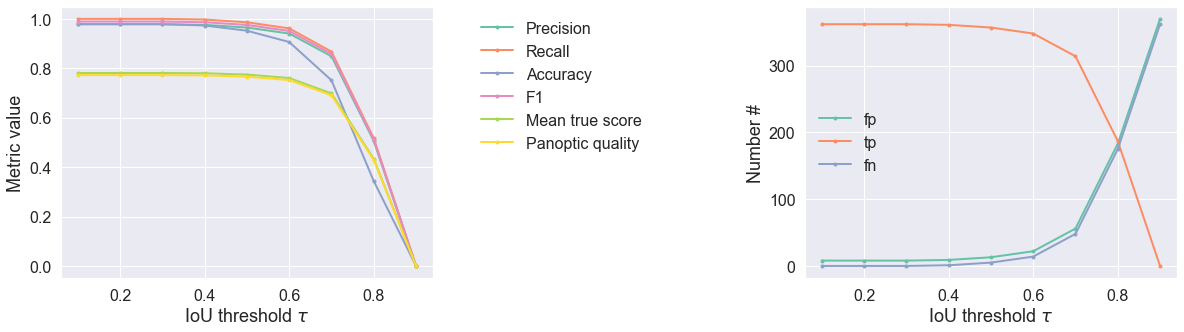

In [64]:
plot_matching_dataset_results(metrics00, taus, save_dir = os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12_multithres_plots.png"))

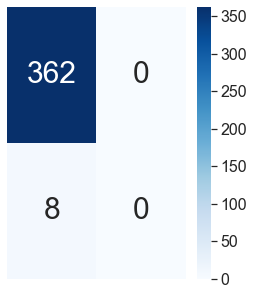

In [76]:
plot_confusion_matrix(metrics00, taus, 0.3, save_dir=os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12_cm.png"))

### Exp12-1

In [55]:
metrics11 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions11).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [05:37<00:00, 37.54s/it]


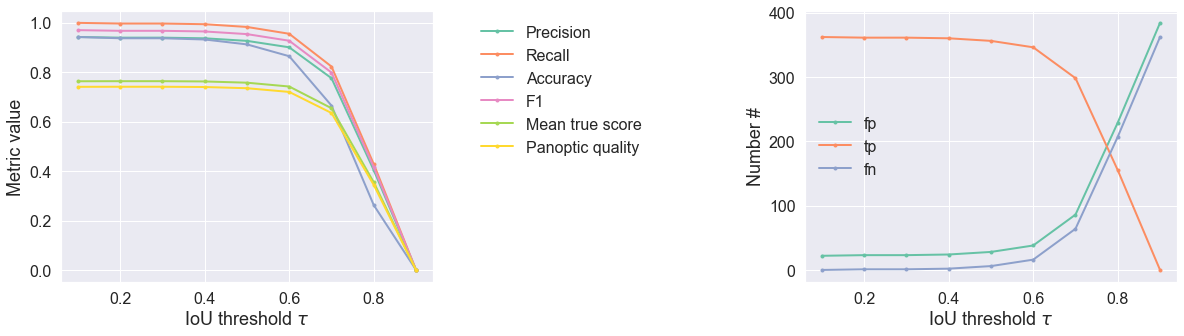

In [58]:
plot_matching_dataset_results(metrics11, taus, save_dir = os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-1_multithres_plots.png"))

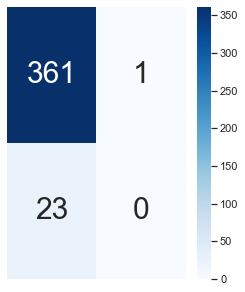

In [62]:
plot_confusion_matrix(metrics11, taus, 0.3, save_dir=os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-1_cm.png"))

### Exp12-2

In [80]:
metrics22 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions22).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:19<00:00, 42.13s/it]


  0%|                                                                                            | 0/9 [19:55<?, ?it/s]


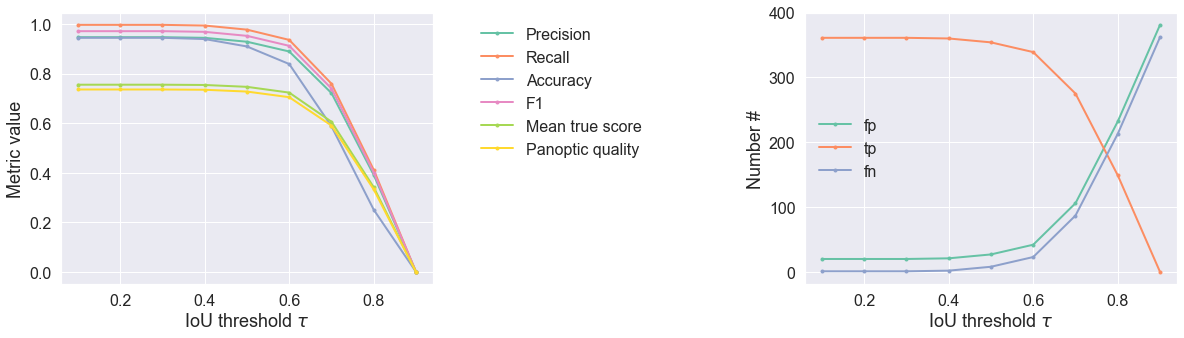

In [81]:
plot_matching_dataset_results(metrics22, taus, save_dir = os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-2_multithres_plots.png"))

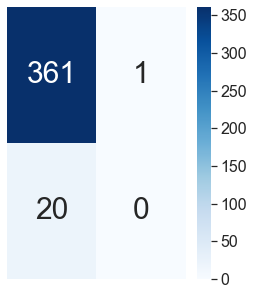

In [82]:
plot_confusion_matrix(metrics22, taus, 0.3, save_dir=os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-2_cm.png"))

### Exp12-3

In [88]:
metrics33 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions33).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:12<00:00, 41.44s/it]


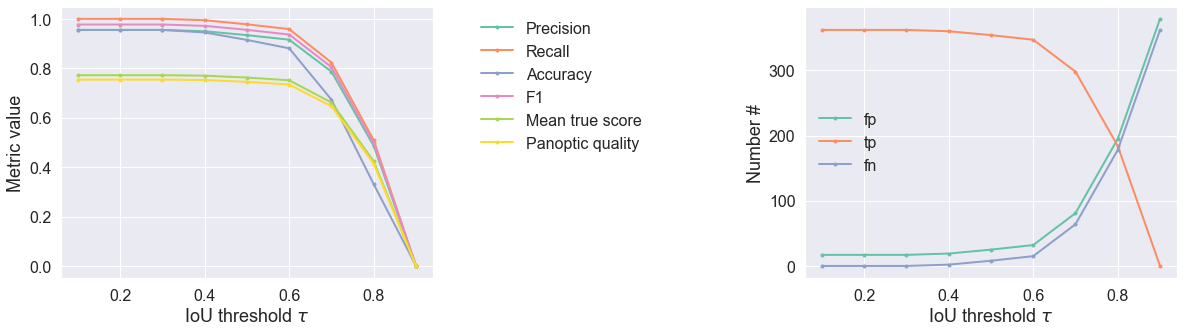

In [89]:
plot_matching_dataset_results(metrics33, taus, save_dir = os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-3_multithres_plots.png"))

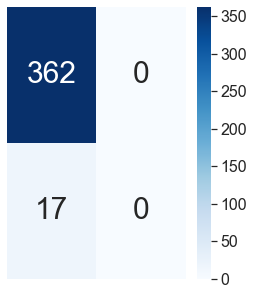

In [90]:
plot_confusion_matrix(metrics33, taus, 0.3, save_dir=os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-3_cm.png"))

### Exp12-4

In [ ]:
metrics44 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions44).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]

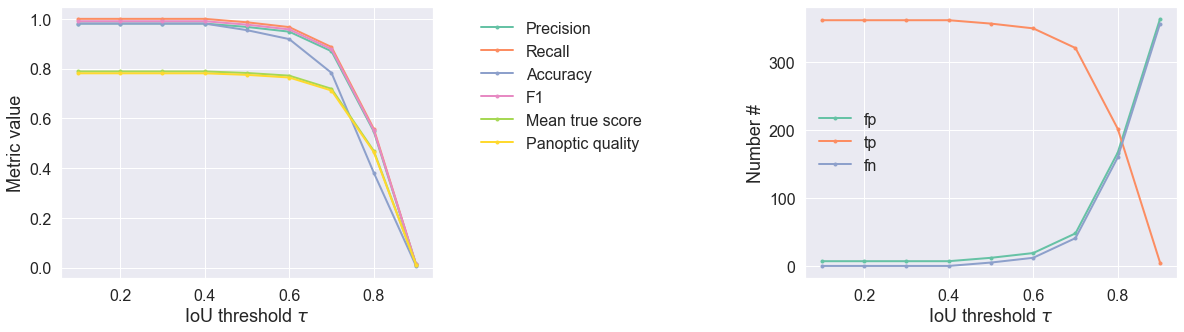

In [68]:
plot_matching_dataset_results(metrics44, taus, save_dir = os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-4_multithres_plots.png"))

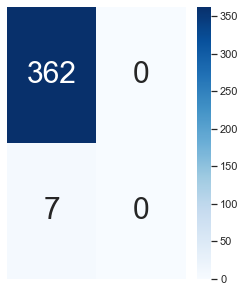

In [113]:
plot_confusion_matrix(metrics44, taus, 0.3, save_dir=os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-4_cm.png"))

#### Exp12-4 after changing NMS thres from default 0.4 to 0.3

In [110]:
metrics44_2 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions44_2).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]



  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

 11%|█████████▎                                                                          | 1/9 [00:39<05:19, 39.92s/it]

 22%|██████████████████▋                                                                 | 2/9 [01:21<04:45, 40.74s/it]

 33%|████████████████████████████                                                        | 3/9 [02:03<04:09, 41.57s/it]

 44%|█████████████████████████████████████▎                                              | 4/9 [02:44<03:26, 41.34s/it]

 56%|██████████████████████████████████████████████▋                                     | 5/9 [03:27<02:47, 41.88s/it]

 67%|████████████████████████████████████████████████████████                            | 6/9 [04:07<02:04, 41.35s/it]

 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [04:49<01:23, 41.52s/it]

 89%|█████████████████████████

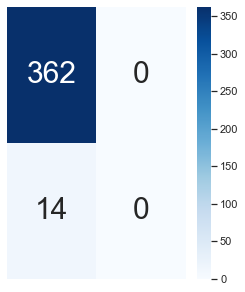

In [112]:
plot_confusion_matrix(metrics44_2, taus, 0.3, save_dir=os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-4_nms0,3_cm.png"))

### Exp12-5

In [73]:
metrics55 = [matching_dataset(np.array(y_true).astype("int32"), np.array(predictions55).astype("int32"), thresh=t, show_progress=False) for t in tqdm(taus)]


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [06:36<00:00, 44.02s/it]


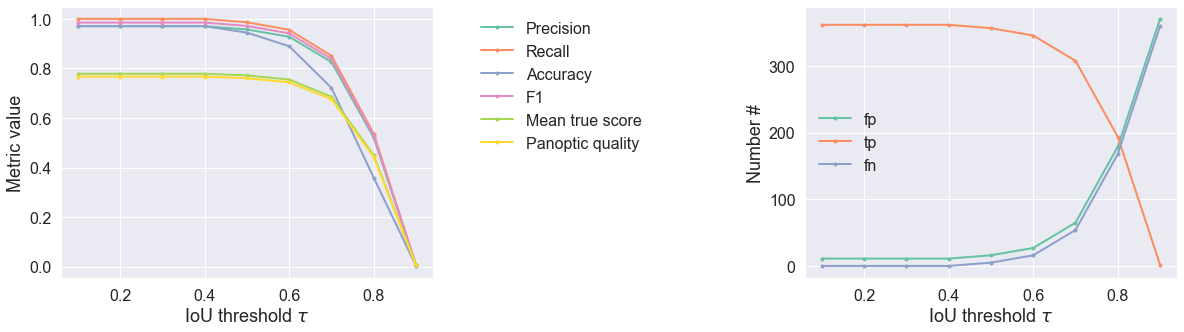

In [74]:
plot_matching_dataset_results(metrics55, taus, save_dir = os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-5_multithres_plots.png"))

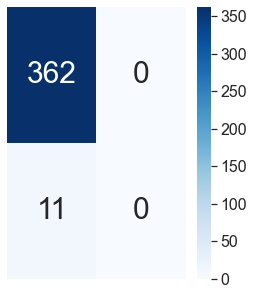

In [75]:
plot_confusion_matrix(metrics55, taus, 0.3, save_dir=os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "exp12-5_cm.png"))

### Plot metrics against Brier scores

In [8]:
df_brier = pd.read_csv(os.path.join(module_path, "notebooks", "results", "APOC_prob_maps", "metrics", "brier_scores_Clf0-20.csv"))

In [9]:
df_brier.describe()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,...,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.045963,0.056263,0.059191,0.057644,0.045503,0.045455,0.044921,0.045556,0.045091,0.044811,...,0.045955,0.048227,0.047994,0.045072,0.041351,0.040056,0.043801,0.044928,0.044528,0.039961
std,0.000455,0.000295,0.000266,0.000493,0.000340,0.000343,0.000198,0.000234,0.000344,0.000144,...,0.000329,0.000545,0.000198,0.000298,0.000424,0.000237,0.000418,0.000427,0.000301,0.000357
min,0.045164,0.055731,0.058852,0.056855,0.045089,0.044886,0.044594,0.045186,0.044520,0.044560,...,0.045404,0.047297,0.047765,0.044603,0.040696,0.039516,0.043214,0.044195,0.044051,0.039424
25%,0.045636,0.056107,0.058978,0.057474,0.045261,0.045172,0.044777,0.045462,0.044835,0.044702,...,0.045739,0.048001,0.047885,0.044908,0.041021,0.039970,0.043564,0.044719,0.044320,0.039673
50%,0.045968,0.056219,0.059223,0.057580,0.045358,0.045505,0.044977,0.045509,0.045056,0.044864,...,0.045986,0.048321,0.047947,0.045075,0.041447,0.040062,0.043865,0.045039,0.044572,0.040007
75%,0.046216,0.056527,0.059346,0.057699,0.045732,0.045657,0.045002,0.045639,0.045324,0.044927,...,0.046141,0.048464,0.048015,0.045159,0.041599,0.040186,0.043942,0.045258,0.044773,0.040251
max,0.046768,0.056689,0.059726,0.058918,0.046119,0.045939,0.045300,0.046040,0.045644,0.045001,...,0.046446,0.049294,0.048483,0.045598,0.042090,0.040382,0.044707,0.045427,0.044952,0.040487


### Convert to the DataFrame suitable for the plot we want

In [30]:
means = df_brier[df_brier.columns].mean()
means

0     0.045963
1     0.056263
2     0.059191
3     0.057644
4     0.045503
5     0.045455
6     0.044921
7     0.045556
8     0.045091
9     0.044811
10    0.045362
11    0.045955
12    0.048227
13    0.047994
14    0.045072
15    0.041351
16    0.040056
17    0.043801
18    0.044928
19    0.044528
20    0.039961
dtype: float64

In [49]:
metrics_all= {}
metrics_all["Clf0"] = [metrics00[2]._asdict()[m] for m in ("precision","accuracy")]  # clf0

In [50]:
metrics_all["Clf1"] = [metrics11[2]._asdict()[m] for m in ("precision","accuracy")]  # clf1

In [51]:
metrics_all["Clf2"] = [metrics22[2]._asdict()[m] for m in ("precision","accuracy")]  # clf2

In [52]:
metrics_all["Clf3"] = [metrics33[2]._asdict()[m] for m in ("precision","accuracy")]  # clf3

In [53]:
metrics_all["Clf4"] = [metrics44[2]._asdict()[m] for m in ("precision","accuracy")]  # clf16

In [54]:
metrics_all["Clf5"] = [metrics55[2]._asdict()[m] for m in ("precision","accuracy")]  # clf20

In [55]:
metrics_all["Clf0"].append(means.iloc[0])

In [56]:
metrics_all["Clf1"].append(means.iloc[1])

In [57]:
metrics_all["Clf2"].append(means.iloc[2])

In [58]:
metrics_all["Clf3"].append(means.iloc[3])

In [59]:
metrics_all["Clf4"].append(means.iloc[16])

In [60]:
metrics_all["Clf5"].append(means.iloc[20])

In [62]:
df_w_brier = pd.DataFrame(metrics_all)
df_w_brier
transposed = df_w_brier.T
transposed=transposed.reset_index()
columns =["clf","precision","Accuracy", "Brier score"]
transposed.columns=columns
transposed

,clf,precision,Accuracy,Brier score
0,Clf0,0.978378,0.978378,0.045963
1,Clf1,0.940104,0.937662,0.056263
2,Clf2,0.947507,0.945026,0.059191
3,Clf3,0.955145,0.955145,0.057644
4,Clf4,0.981030,0.981030,0.040056
5,Clf5,0.970509,0.970509,0.039961


_decorators.py (36): Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


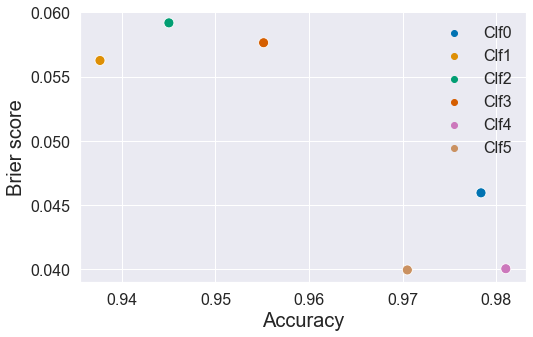

In [70]:
f, ax = plt.subplots(1, figsize = (8,5))
sns.scatterplot('Accuracy', 'Brier score', data = transposed, hue = 'clf', palette="colorblind", ax=ax, s=100)
ax.legend(frameon=False)

plt.savefig(os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "Brier_score_vs_acc.png"),bbox_inches='tight')

### Plot metrics vs threshold values of overlap based matching

In [318]:
metric={"index":taus}
for m,t in zip(('fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"),taus):
    metric[m]=[metrics00[taus.index(t)]._asdict()[m] for t in taus]
dfs=pd.DataFrame.from_dict(metric, orient='index')
metric={"index":taus}
for m,t in zip(('fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"),taus):
    metric[m]=[metrics11[taus.index(t)]._asdict()[m] for t in taus]
dfs3=pd.DataFrame.from_dict(metric, orient='index')
metric={"index":taus}
for m,t in zip(('fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"),taus):
    metric[m]=[metrics22[taus.index(t)]._asdict()[m] for t in taus]
dfs4=pd.DataFrame.from_dict(metric, orient='index')
metric={"index":taus}
for m,t in zip(('fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"),taus):
    metric[m]=[metrics33[taus.index(t)]._asdict()[m] for t in taus]
dfs5=pd.DataFrame.from_dict(metric, orient='index')
metric={"index":taus}
for m,t in zip(('fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"),taus):
    metric[m]=[metrics44[taus.index(t)]._asdict()[m] for t in taus]
dfs6=pd.DataFrame.from_dict(metric, orient='index')
metric={"index":taus}
for m,t in zip(('fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"),taus):
    metric[m]=[metrics55[taus.index(t)]._asdict()[m] for t in taus]
dfs7=pd.DataFrame.from_dict(metric, orient='index')

In [319]:
alldf=pd.concat([dfs.T, dfs3.T, dfs4.T, dfs5.T, dfs6.T, dfs7.T])
alldf =alldf.reset_index()

In [327]:
alldf.describe()

,level_0,index,fn,fp,precision,recall,accuracy,f1,mean_true_score,mean_matched_score,panoptic_quality
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,4.000000,0.500000,69.796296,83.796296,0.777469,0.807193,0.741771,0.792007,0.632752,0.733375,0.620901
std,2.606233,0.260623,118.722664,119.047855,0.316319,0.327963,0.333526,0.321953,0.252193,0.211593,0.247759
min,0.000000,0.100000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.300000,0.000000,13.750000,0.778601,0.823204,0.667055,0.800275,0.656216,0.770960,0.637946
50%,4.000000,0.500000,5.500000,23.000000,0.940104,0.984807,0.925639,0.961370,0.756749,0.780844,0.738359
75%,6.000000,0.700000,64.000000,84.750000,0.962925,1.000000,0.955145,0.977058,0.773923,0.797336,0.765631
max,8.000000,0.900000,362.000000,384.000000,0.981030,1.000000,0.981030,0.990424,0.788743,0.906009,0.781190


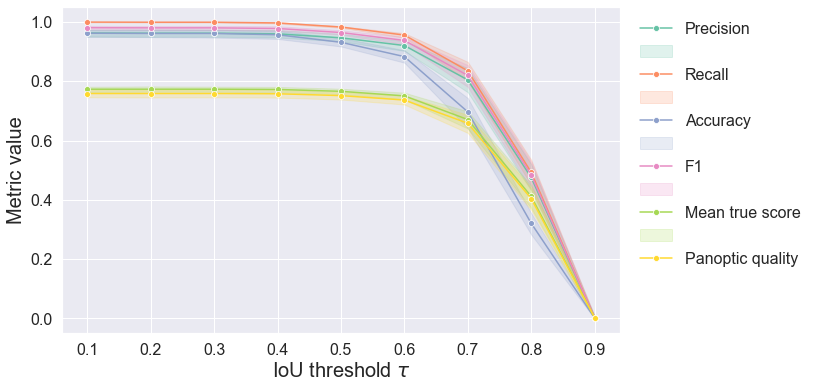

In [326]:
labels = ('Precision', "", 'Recall', "", 'Accuracy', "",'F1', "",'Mean true score', "",'Panoptic quality')

fig, (ax) = plt.subplots(1,1, figsize=(10,6))

sns.lineplot(x="index", y="precision", data=alldf, markers=True, marker='o', ax=ax,legend="auto")
sns.lineplot(x="index", y="recall", data=alldf, markers=True, marker='o', ax=ax)
sns.lineplot(x="index", y="accuracy", data=alldf, markers=True, marker='o', ax=ax)
sns.lineplot(x="index", y="f1", data=alldf, markers=True, marker='o', ax=ax)
sns.lineplot(x="index", y="mean_true_score", data=alldf, markers=True, marker='o', ax=ax)
sns.lineplot(x="index", y="panoptic_quality", data=alldf, markers=True, marker='o', ax=ax)

ax.set_xlabel(r'IoU threshold $\tau$')
ax.set_ylabel('Metric value')
ax.legend(labels, loc='upper right', frameon=False, bbox_to_anchor=(1.35, 1))

plt.savefig(os.path.join(module_path, "reports", "figures", "stardist", "trained_on_pmaps", "mean_multithres_plot.png"))

### Save metrics 

In [102]:
save_stardist_matching_named_tuple_metrics("metrics/exp12_pred_on_pmaps", metrics00, taus)

In [103]:
save_stardist_matching_named_tuple_metrics("metrics/exp12-1_pred_on_pmaps", metrics11, taus)

In [104]:
save_stardist_matching_named_tuple_metrics("metrics/exp12-2_pred_on_pmaps", metrics22, taus)

In [105]:
save_stardist_matching_named_tuple_metrics("metrics/exp12-3_pred_on_pmaps", metrics33, taus)

In [106]:
save_stardist_matching_named_tuple_metrics("metrics/exp12-4_pred_on_pmaps", metrics44, taus)

In [107]:
save_stardist_matching_named_tuple_metrics("metrics/exp12-5_pred_on_pmaps", metrics55, taus)

### Load saved metrics

In [18]:
metrics00 = load_stardist_matching_named_tuple_metrics(taus, os.path.join(module_path, "notebooks", "results", "Stardist", "trained_on_pmaps", "metrics", "exp12_pred_on_pmaps"))

In [21]:
metrics11 = load_stardist_matching_named_tuple_metrics(taus, os.path.join(module_path, "notebooks", "results", "Stardist", "trained_on_pmaps", "metrics", "exp12-1_pred_on_pmaps"))

In [22]:
metrics22 = load_stardist_matching_named_tuple_metrics(taus, os.path.join(module_path, "notebooks", "results", "Stardist", "trained_on_pmaps", "metrics", "exp12-2_pred_on_pmaps"))

In [23]:
metrics33 = load_stardist_matching_named_tuple_metrics(taus, os.path.join(module_path, "notebooks", "results", "Stardist", "trained_on_pmaps", "metrics", "exp12-3_pred_on_pmaps"))

In [19]:
metrics44 = load_stardist_matching_named_tuple_metrics(taus, os.path.join(module_path, "notebooks", "results", "Stardist", "trained_on_pmaps", "metrics", "exp12-4_pred_on_pmaps"))

In [20]:
metrics55 = load_stardist_matching_named_tuple_metrics(taus, os.path.join(module_path, "notebooks", "results", "Stardist", "trained_on_pmaps", "metrics", "exp12-5_pred_on_pmaps"))

### Distance-based metrics

#### Exp12

In [ ]:
res_df = get_boundary_based_metrics_per_object(predictions00, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels

In [ ]:
pd.set_option('display.max_rows', res_df.shape[0]+1)
res_df_wo_nans= res_df.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])
final = res_df_wo_nans.reset_index(drop=True)
final

In [ ]:
final.to_csv(r"metrics/exp12_distance_metrics_df.csv")

#### Exp12-1

In [ ]:
res_df1 = get_boundary_based_metrics_per_object(predictions11, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels

In [ ]:
pd.set_option('display.max_rows', res_df1.shape[0]+1)
res_df_wo_nans1= res_df1.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])
final1 = res_df_wo_nans1.reset_index(drop=True)
final1

In [ ]:
final1.to_csv(r"metrics/exp12-1_distance_metrics_df.csv")

#### Exp12-2

In [ ]:
res_df2 = get_boundary_based_metrics_per_object(predictions22, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels

In [ ]:
pd.set_option('display.max_rows', res_df2.shape[0]+1)
res_df_wo_nans2= res_df2.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])
final2 = res_df_wo_nans2.reset_index(drop=True)
final2

In [ ]:
final2.to_csv(r"metrics/exp12-2_distance_metrics_df.csv")

#### Exp12-3

In [ ]:
res_df3 = get_boundary_based_metrics_per_object(predictions33, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels

In [ ]:
pd.set_option('display.max_rows', res_df3.shape[0]+1)
res_df_wo_nans1= res_df3.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])
final3 = res_df_wo_nans3.reset_index(drop=True)
final3

In [ ]:
final3.to_csv(r"metrics/exp12-3_distance_metrics_df.csv")

#### Exp12-4

In [ ]:
res_df4 = get_boundary_based_metrics_per_object(predictions44, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels
res_df4

In [ ]:
pd.set_option('display.max_rows', res_df4.shape[0]+1)
res_df_wo_nans4= res_df.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])
final4 = res_df_wo_nans4.reset_index(drop=True)
final4

In [ ]:
final4.to_csv(r"metrics/exp12-4_distance_metrics_df.csv")

#### Exp12-5

In [ ]:
res_df5 = get_boundary_based_metrics_per_object(predictions55, y_true, spacing_mm= (0.000173, 0.000173, 0.000173), hausdorff_percent=95.0, tolerance_mm=0.000173*3)   # tolerance is 3 pixels

In [ ]:
pd.set_option('display.max_rows', res_df5.shape[0]+1)
res_df_wo_nans5= res_df.dropna(subset=["DSCvol", "surf_overlap_of_pred_surf_w_gt_surf"])
final5 = res_df_wo_nans5.reset_index(drop=True)
final5

In [123]:
final5.to_csv(r"metrics/exp12-5_distance_metrics_df.csv")

### Take a look at some

In [152]:
final.describe()

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
count,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000
mean,0.612882,0.362219,2.068843,0.671546,0.790108,0.723132,0.872728
std,0.423110,0.105595,1.627368,0.133740,0.098897,0.119182,0.057714
min,0.195399,0.185860,0.519000,0.266004,0.420500,0.325306,0.607072
25%,0.370896,0.291126,1.066444,0.567749,0.728488,0.630803,0.844229
50%,0.476949,0.342575,1.503201,0.690975,0.807027,0.735425,0.892339
75%,0.690633,0.426517,2.434326,0.766590,0.862288,0.811072,0.911568
max,3.234147,0.957810,10.183515,0.953098,0.981512,0.966761,0.948291


In [150]:
final2.describe()

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
count,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000
mean,0.571278,0.341606,1.940047,0.693093,0.811771,0.745004,0.879453
std,0.393124,0.095243,1.468884,0.127862,0.095586,0.114082,0.054859
min,0.171227,0.162672,0.423762,0.311618,0.446856,0.370556,0.599492
25%,0.352410,0.269031,1.073370,0.613408,0.756979,0.677634,0.860981
50%,0.464180,0.327330,1.483157,0.707121,0.825306,0.763156,0.894231
75%,0.643766,0.385826,2.255644,0.793406,0.882142,0.834570,0.915141
max,3.177694,0.729313,10.173224,0.979060,0.994245,0.984894,0.953115


In [149]:
final3.describe()

,avrg_d_from_gt_to_pred,avrg_d_from_pred_to_gt,HD95,surf_overlap_of_gt_surf_w_pred_surf,surf_overlap_of_pred_surf_w_gt_surf,DSCsurf,DSCvol
count,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000
mean,0.596469,0.361010,2.011644,0.677993,0.791190,0.727642,0.874381
std,0.404086,0.098544,1.589145,0.130150,0.097330,0.116060,0.056164
min,0.207304,0.196948,0.519000,0.263960,0.406288,0.320726,0.547271
25%,0.362275,0.286526,1.052318,0.590290,0.729711,0.653486,0.851736
50%,0.472260,0.344175,1.442234,0.688055,0.803287,0.738364,0.890566
75%,0.676971,0.416962,2.426628,0.780438,0.865627,0.817189,0.912139
max,3.269956,1.016541,11.769087,0.954142,0.977761,0.965673,0.945928


### Plot distance metrics of 3 models

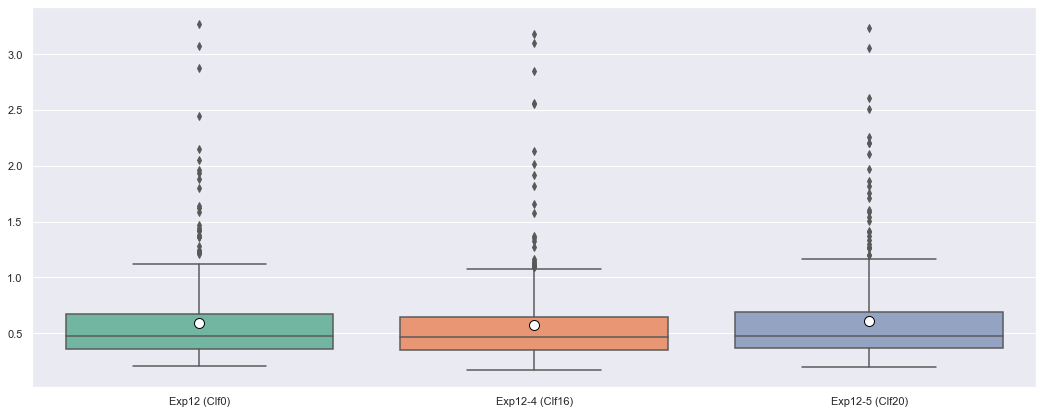

In [143]:
df = pd.concat([final3["avrg_d_from_gt_to_pred"], final2["avrg_d_from_gt_to_pred"], final["avrg_d_from_gt_to_pred"]], axis = 1)
df.columns =["Exp12 (Clf0)","Exp12-4 (Clf16)","Exp12-5 (Clf20)"]
f, ax = plt.subplots(1, figsize = (18,7))
sns.boxplot(data=df[["Exp12 (Clf0)", "Exp12-4 (Clf16)", "Exp12-5 (Clf20)"]], showmeans=True, ax = ax, meanprops={"marker":"o",
                                                                                                                 "markerfacecolor":"white", 
                                                                                                                 "markeredgecolor":"black",
                                                                                                                 "markersize":"10"})
plt.savefig(os.path.join(module_path, "reports", "figures", "vollseg", "exp12_distance_metrics_avrg_d_from_gt_to_pred_boxplot.png"), bbox_inches='tight')

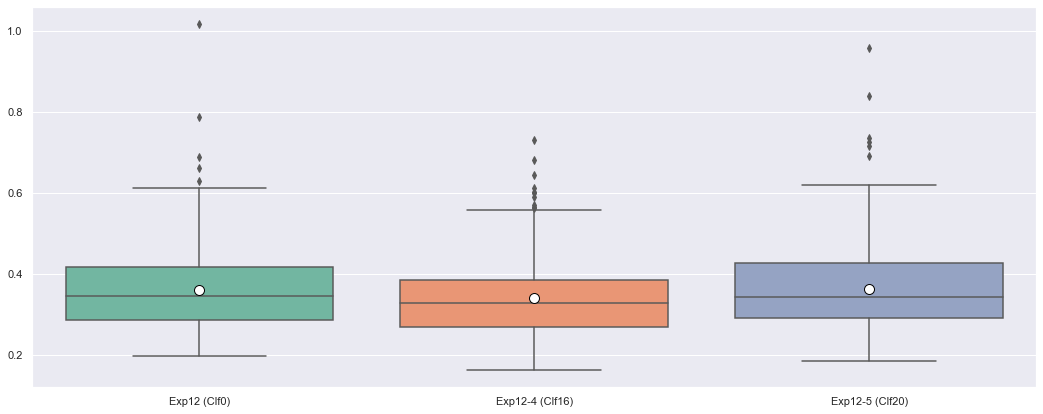

In [144]:
df = pd.concat([final3["avrg_d_from_pred_to_gt"], final2["avrg_d_from_pred_to_gt"], final["avrg_d_from_pred_to_gt"]], axis = 1)
df.columns =["Exp12 (Clf0)","Exp12-4 (Clf16)","Exp12-5 (Clf20)"]
f, ax = plt.subplots(1, figsize = (18,7))
sns.boxplot(data=df[["Exp12 (Clf0)", "Exp12-4 (Clf16)", "Exp12-5 (Clf20)"]], showmeans=True, ax = ax, meanprops={"marker":"o",
                                                                                                                 "markerfacecolor":"white", 
                                                                                                                 "markeredgecolor":"black",
                                                                                                                 "markersize":"10"})
plt.savefig(os.path.join(module_path, "reports", "figures", "vollseg", "exp12_distance_metrics_avrg_d_from_pred_to_gt_boxplot.png"), bbox_inches='tight')

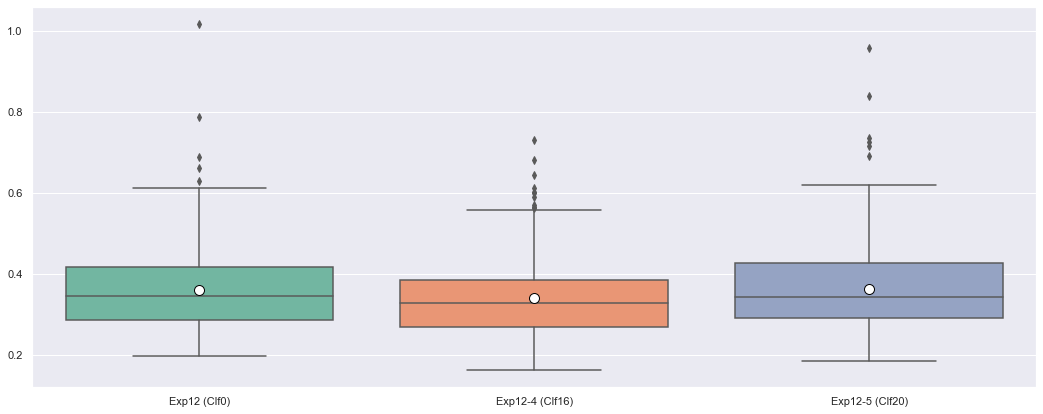

In [145]:
avrg_d_from_pred_to_gtdf = pd.concat([final3["HD95"], final2["HD95"], final["HD95"]], axis = 1)
df.columns =["Exp12 (Clf0)","Exp12-4 (Clf16)","Exp12-5 (Clf20)"]
f, ax = plt.subplots(1, figsize = (18,7))
sns.boxplot(data=df[["Exp12 (Clf0)", "Exp12-4 (Clf16)", "Exp12-5 (Clf20)"]], showmeans=True, ax = ax, meanprops={"marker":"o",
                                                                                                                 "markerfacecolor":"white", 
                                                                                                                 "markeredgecolor":"black",
                                                                                                                 "markersize":"10"})
plt.savefig(os.path.join(module_path, "reports", "figures", "vollseg", "exp12_distance_metrics_hd95_boxplot.png"), bbox_inches='tight')

### Save combined metrics of the best model

In [155]:
metrics_combined = {
    'Mean distance from the GT to predicted surface in microns': final2["avrg_d_from_gt_to_pred"].mean(),
    "Mean distance from predicted to the GT surface in microns": final2["avrg_d_from_pred_to_gt"].mean(),
    "Mean Hausdorff95 distance": final2["HD95"].mean(),
    "Mean surface overlap fraction of GT surfaces with predicted surfaces": final2["surf_overlap_of_gt_surf_w_pred_surf"].mean(),
    "Mean surface overlap fraction of the predicted surfaces with the GT surfaces": final2["surf_overlap_of_pred_surf_w_gt_surf"].mean(),
    "Mean surface DSC": final2["DSCsurf"].mean(),
    "Mean volume DSC over matched objects": final2["DSCvol"].mean(),
}

for m in ('tp', 'fn', 'fp', "precision", "recall", "accuracy", "f1", "mean_true_score", "mean_matched_score", "panoptic_quality"):
    metrics_combined[m] = metrics44[2]._asdict()[m]
metrics_combined

{'Mean distance from the GT to predicted surface in microns': 0.5712783590222684,
 'Mean distance from predicted to the GT surface in microns': 0.34160627409136274,
 'Mean Hausdorff95 distance': 1.9400469032481662,
 'Mean surface overlap fraction of GT surfaces with predicted surfaces': 0.6930927686354982,
 'Mean surface overlap fraction of the predicted surfaces with the GT surfaces': 0.8117709526476165,
 'Mean surface DSC': 0.7450038853809553,
 'Mean volume DSC over matched objects': 0.8794532368404403,
 'tp': 362,
 'fn': 0,
 'fp': 7,
 'precision': 0.981029810298103,
 'recall': 1.0,
 'accuracy': 0.981029810298103,
 'f1': 0.9904240766073872,
 'mean_true_score': 0.7887431679509621,
 'mean_matched_score': 0.7887431679509621,
 'panoptic_quality': 0.7811902237982169}

In [156]:
import json

with open("metrics/exp12_metrics_best.json", "w") as f:
    json.dump(metrics_combined, f) 